# Estrategia 03
---

Para esta estrategia se utilizó una SVM y features específicas de *intensidad* y *geometría*. Además, se utilizó *PCA* para la transformación de caracterísiticas.

---
## 1) Carga de Datos

In [10]:
import numpy as np
import os

# data directory path
DATADIR = 'data'

# carga de datos de training
x_training = np.load(os.path.join(DATADIR, 'training', 'dataset_features.npy'), allow_pickle=True)
label_training = np.load(os.path.join(DATADIR, 'training', 'dataset_labels.npy'), allow_pickle=True)
d_train = np.array([int(y[1:3]) for y in label_training])

# carga de datos de testing
x_testing = np.load(os.path.join(DATADIR, 'testing', 'dataset_features.npy'), allow_pickle=True)
label_testing = np.load(os.path.join(DATADIR, 'testing', 'dataset_labels.npy'), allow_pickle=True)
d_test = np.array([int(y[1:3]) for y in label_testing])

# features_label
flabels = np.load(os.path.join(DATADIR, 'flabels.npy'), allow_pickle=True)

### - Uso de caracteristicas:

- Para esta estrategia se ocuparon features **geometricas** y una caracteristica de **intensidad**. La hipótesis detrás de esta estrategia es poder ver qué tipo de característica es la más eficiente dentro de este último grupo.
    
    1. Flusser Moments ( *geométrico* ).
    2. Hu Moments ( *geométrico* ).
    3. Gabor Features ( *intensity* ).

In [11]:
to_use = ['gabor', 'flusser', 'hu']

use_columns = []
for label in flabels:  # nombre de la feature
    for ftype in to_use:  # nombres de las features que queremos usar
        if ftype in label:
            use_columns.append(*np.where(flabels == label)[0])  # agregamos el indice de la feature

print(f'Using only {len(use_columns)} features...')

# selecionamos solo esas columnas
x_train = x_training[:, use_columns]
x_test = x_testing[:, use_columns]

Using only 78 features...


## 2) Transformación y Selección de Características

- En esta estrategia se van a utilizar los siguientes procesos de transformación y selección de caracterísiticas:

    1. Normalization (```mean```).
    2. PCA (```n_components = 15```)


### - Training:

In [47]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

N_COMPONENTS = 15

# Training: Normalization
scaler = StandardScaler()
scaler.fit(x_train)
x_train_norm = scaler.transform(x_train)
print('Normalized       : ' + str(x_train_norm.shape[1]) + ' features.')

# Training: PCA transformation
pca = PCA(n_components=N_COMPONENTS)
pca.fit(x_train_norm)
x_train_pca = pca.transform(x_train_norm)
print('After PCA        : ' + str(x_train_pca.shape[1]) + ' features.')

Normalized       : 78 features.
After PCA        : 15 features.


### - Testing:

In [48]:
# Testing: Normalization
x_test_norm = scaler.transform(x_test)

# Testing: PCA transformation
x_test_pca = pca.transform(x_test_norm)

print('Testing ft: '+ str(x_test_pca.shape[1]) + ' from (' + str(x_test_pca.shape[0]) + ' samples)')

Testing ft: 15 from (1260 samples)


## 3) Classification:

La clasificación para cada patch se hizo a través de una *Support Vector Machine*, a continuación se ve la implementación:

### - Clasificador individual:

Accuracy:  0.945


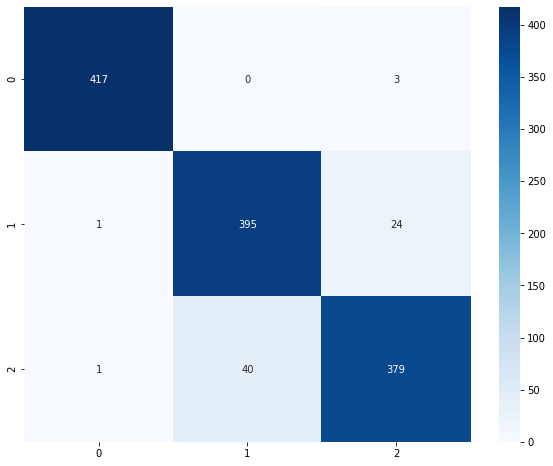

In [49]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns

KERNEL = 'rbf'  # linear, poly, rbf, sigmoid
GAMMA = 'scale'    # scale, auto

# Classification on Testing dataset
svm = SVC(kernel=KERNEL, gamma=GAMMA)
svm.fit(x_train_pca, d_train)

predicted = svm.predict(x_test_pca)

acc = accuracy_score(d_test, predicted)
print('Accuracy: ', round(acc, 3))

cmatrix = confusion_matrix(d_test, predicted)


fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(cmatrix, cmap="Blues", annot=True, ax=ax, fmt='g')

### - Clasificador Grupal:

Para la clasificación grupal se vota según cada *patch* que conforma a la imagen.

In [50]:
# contadores por clase y tipo de votos
votes = {'00': {}, '01': {}, '02': {}}
for i in range(label_testing.shape[0]):
    label = label_testing[i]
    # si aún no se agrega esta clase
    if not label[4:8] in votes[label[1:3]].keys():
        votes[label[1:3]][label[4:8]] = [predicted[i]]
    else:
        votes[label[1:3]][label[4:8]].append(predicted[i])

In [51]:
# hacemos la clasificación en grupos vamos a contruir un predict and true value
group_predicted = []
group_true_value = []
for cnumber in votes:
    for gnumber in votes[cnumber]:
        group_true_value.append(int(cnumber))
        predicted_list = votes[cnumber][gnumber]
        group_predicted.append(max(set(predicted_list), key=predicted_list.count))
g_predicted = np.array(group_predicted)
g_test = np.array(group_true_value)

Accuracy:  0.976


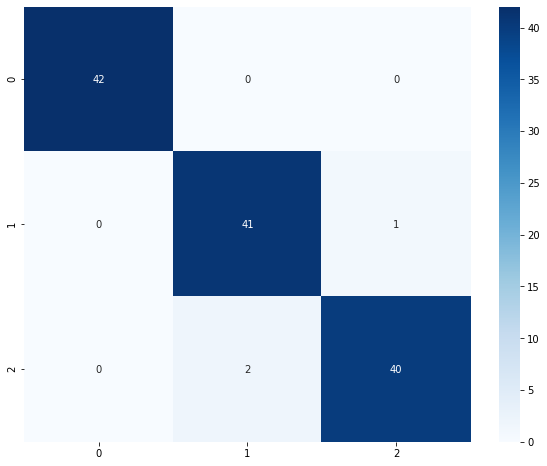

In [52]:
# estadisticas por grupos
g_acc = accuracy_score(g_test, g_predicted)
print('Accuracy: ', round(g_acc, 3))

g_cmatrix = confusion_matrix(g_test, g_predicted)

fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(g_cmatrix, cmap="Blues", annot=True, ax=ax, fmt='g')